In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
import os

<span style="font-size:18px; color:green;">Подтягиваем данные рекламы</span>

In [3]:
ads = pd.read_csv('./ads.csv')

In [4]:
print(ads)

                    date utm_source utm_medium                utm_campaign  \
0    2023-03-01T10:54:41     google        cpc  advanced_algorithms_series   
1    2023-03-02T10:32:35     google        cpc  advanced_algorithms_series   
2    2023-03-03T19:21:40     google        cpc  advanced_algorithms_series   
3    2023-03-04T17:52:04     google        cpc  advanced_algorithms_series   
4    2023-03-05T05:35:13     google        cpc  advanced_algorithms_series   
..                   ...        ...        ...                         ...   
154  2023-09-13T05:34:02         vk     social      intro_to_python_course   
155  2023-09-14T18:25:13         vk     social      intro_to_python_course   
156  2023-09-15T15:35:47         vk     social      intro_to_python_course   
157  2023-09-16T05:30:26         vk     social      intro_to_python_course   
158  2023-09-17T02:04:39         vk     social      intro_to_python_course   

     cost  
0     212  
1     252  
2     202  
3     223  
4  

<span style="font-size:18px; color:green;">Убираем лишние даты. Мб так не надо</span>

In [6]:
start_date = '2023-03-01'
end_date = '2023-09-01'

In [7]:
ads = ads[(ads['date'] >= start_date) & (ads['date'] <= end_date)]

<span style="font-size:18px; color:green;">Делаем дату датой, убираем время</span>

In [9]:
ads['date'] = pd.to_datetime(ads['date'])

In [10]:
ads['date'] = ads['date'].dt.date

<span style="font-size:18px; color:green;">Агрегируем по дате и кампании</span>

In [12]:
ads_itog = ads.groupby(['date','utm_campaign'])['cost'].agg(['sum'])

In [13]:
ads_itog = ads_itog.reset_index()

<span style="font-size:18px; color:green;">Приводим к одному формату с ads_ag, чтобы работал мердж</span>

In [15]:
ads_itog['date'] = pd.to_datetime(ads_itog['date'])

In [16]:
print(ads_itog)

          date                utm_campaign  sum
0   2023-03-01  advanced_algorithms_series  212
1   2023-03-02  advanced_algorithms_series  252
2   2023-03-03  advanced_algorithms_series  202
3   2023-03-04  advanced_algorithms_series  223
4   2023-03-05  advanced_algorithms_series  265
..         ...                         ...  ...
137 2023-08-27      intro_to_python_course  222
138 2023-08-28      intro_to_python_course  223
139 2023-08-29      intro_to_python_course  190
140 2023-08-30      intro_to_python_course  109
141 2023-08-31      intro_to_python_course  215

[142 rows x 3 columns]


<span style="font-size:28px; color:red;">3 ШАГ</span>

<span style="font-size:18px; color:green;">Создаем папку для графиков</span>

In [19]:
os.makedirs("./charts", exist_ok=True)

<span style="font-size:18px; color:green;">Считываем переменные окружения</span>

In [21]:
load_dotenv()

True

In [22]:
DATE_BEGIN = os.getenv('DATE_BEGIN')
DATE_END = os.getenv('DATE_END')
API_URL = os.getenv('API_URL')

<span style="font-size:18px; color:green;">Чтение данных с сайта</span>

In [24]:
regs = requests.get(f'{API_URL}/registrations', params={'begin': DATE_BEGIN, 'end': DATE_END})
print(regs.status_code)

200


In [25]:
visits = requests.get(f'{API_URL}/visits', params={'begin': DATE_BEGIN, 'end': DATE_END})
print(visits.status_code)

200


<span style="font-size:18px; color:green;">Переводим в json и делаем dataframe</span>

In [27]:
visits_json = visits.json()

In [28]:
regs_json = regs.json()

In [29]:
df_r = pd.DataFrame(regs_json)

<span style="font-size:18px; color:green;">Преобразовываем дату, убирая время</span>

In [31]:
df_r['datetime'] = pd.to_datetime(df_r['datetime'])

In [32]:
df_r['datetime'] = df_r['datetime'].dt.date

<span style="font-size:18px; color:green;">Агрегируем, получаем рабочую таблицу по РЕГИСТРАЦИЯМ</span>

In [34]:
regs_itog = df_r.groupby(['datetime','platform'])['user_id'].agg(['count'])

<span style="font-size:23px; color:blue;">ПОСТРОЕНИЕ ГРАФИКА 1</span>

In [36]:
regs_for_plot = df_r.groupby(['datetime'])['user_id'].agg(['count'])

In [37]:
regs_for_plot = regs_for_plot.reset_index()

In [38]:
regs_for_plot = regs_for_plot.rename(columns={'datetime': 'date_group', 'count': 'registrations' })

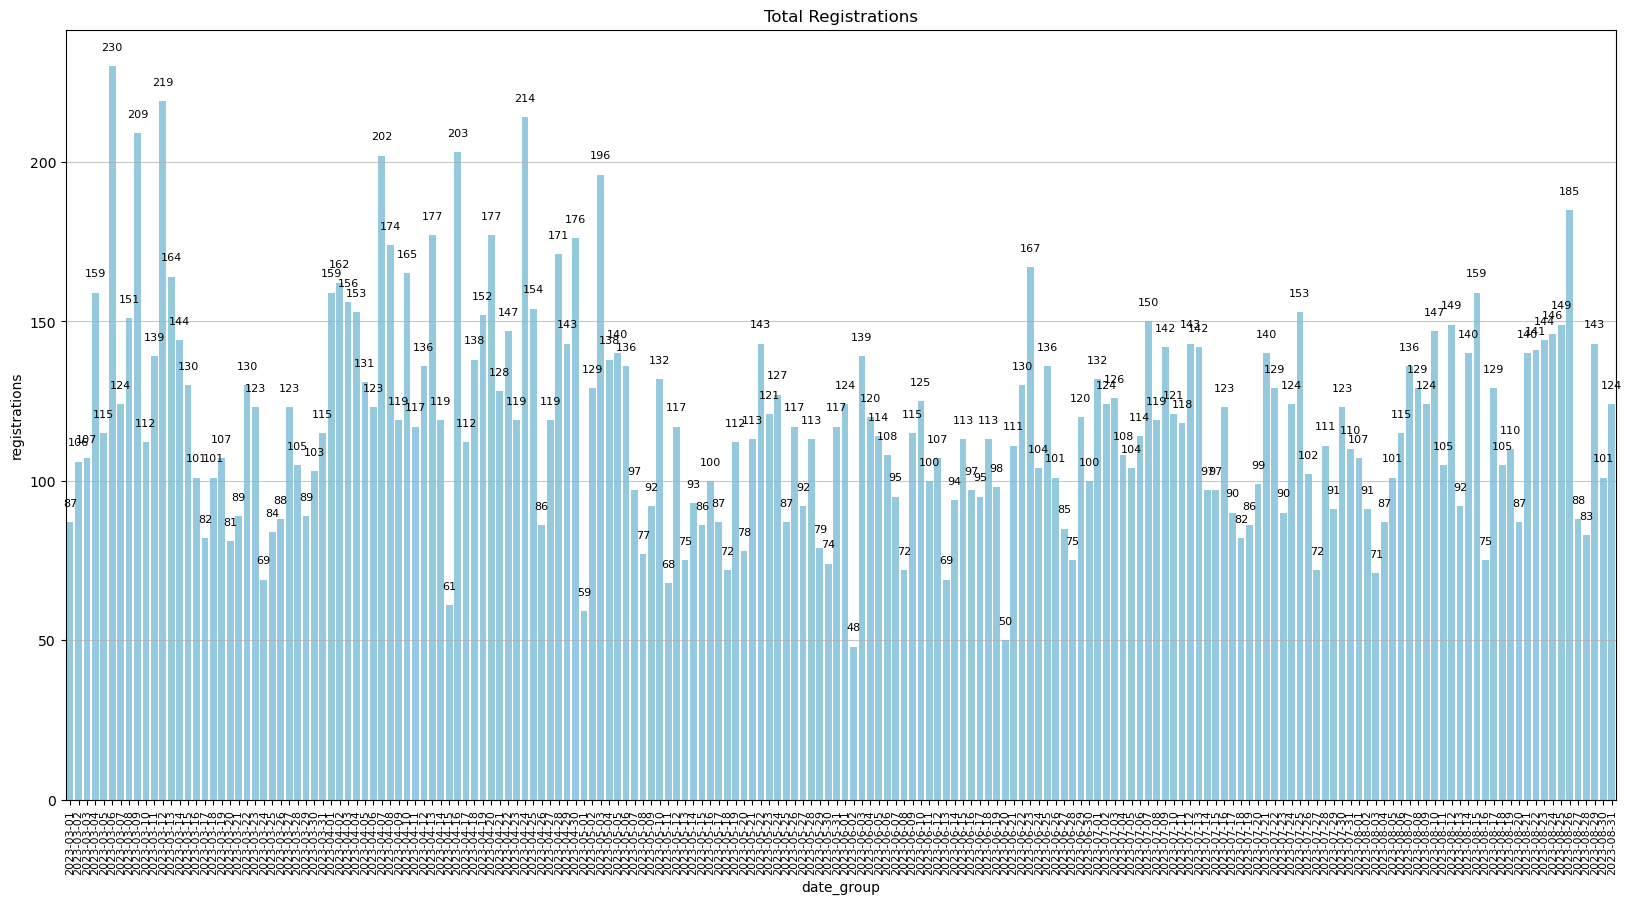

In [39]:
plt.figure(figsize=(20, 10))
gr = sns.barplot(data=regs_for_plot, x='date_group', y='registrations', color='skyblue')

for i, v in enumerate(regs_for_plot['registrations']):
    plt.text(i, v + 5, str(v), ha='center', fontsize=8)
    
plt.xticks(rotation=90, fontsize=8)
plt.xlabel("date_group")
plt.ylabel("registrations")
plt.title("Total Registrations")
plt.grid(axis='y', linestyle="-", alpha=0.7)
plt.savefig(f'./charts/chart1.png')
plt.show()

<span style="font-size:23px; color:blue;">ПОСТРОЕНИЕ ГРАФИКА 2</span>

In [41]:
agr_reg_for_plt = regs_itog.reset_index()

In [42]:
agr_reg_for_plt = agr_reg_for_plt.pivot(index='datetime', columns='platform', values='count')#подготавливаем для разбтвки

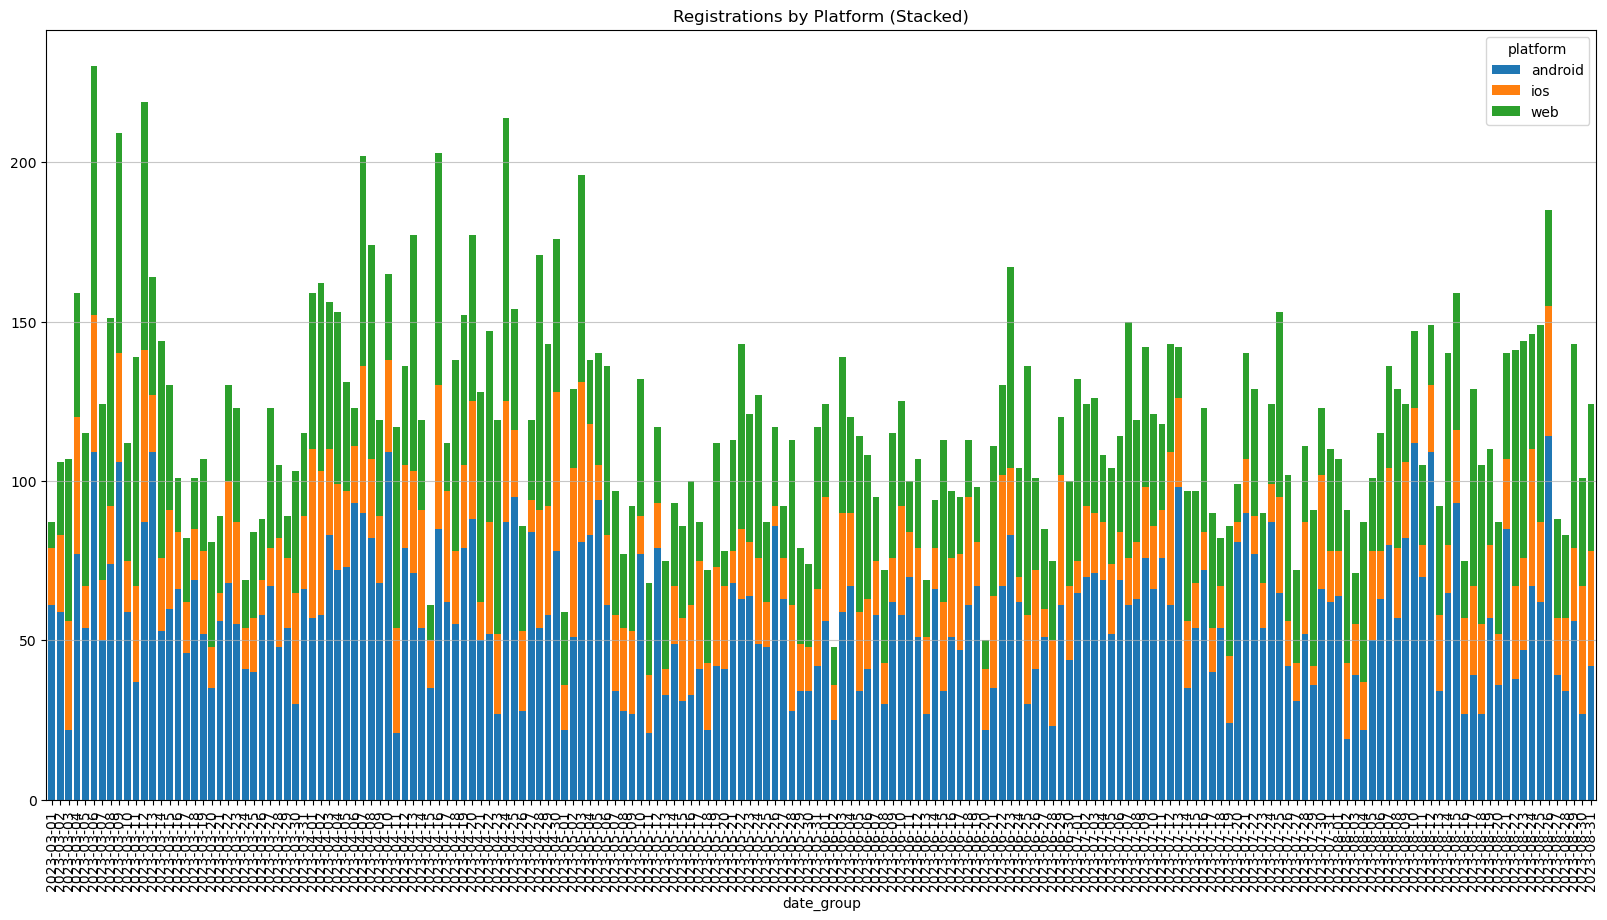

In [43]:
#plt.figure(figsize=(20, 10))

agr_reg_for_plt.plot(kind='bar', stacked=True, figsize=(20, 10), width=0.8)

plt.title("Registrations by Platform (Stacked)")
plt.xlabel("date_group")
plt.xticks(rotation=90)#наклон подписей по X
plt.legend(title="platform")
plt.grid(axis='y', linestyle="-", alpha=0.7)
#plt.grid(axis='x', linestyle="-", alpha=0.7)
plt.savefig(f'./charts/chart2.png')
plt.show()

<span style="font-size:18px; color:green;">Работа с визитами</span>

In [45]:
df_v = pd.DataFrame(visits_json)

<span style="font-size:18px; color:green;">Обработка данных: редактируем дату, убираем ботов, берем последний визит</span>

In [47]:
df_v['datetime'] = pd.to_datetime(df_v['datetime'])#перевели в дату

In [48]:
df_v = df_v[~df_v['user_agent'].str.contains('bot', case=False, na=False)]#удалили ботов

In [49]:
df_v = df_v.loc[df_v.groupby('visit_id')['datetime'].idxmax()]#последняя дата

In [50]:
df_v['datetime'] = df_v['datetime'].dt.date

<span style="font-size:18px; color:green;">Агрегируем, получаем рабочую таблицу по ВИЗИТАМ</span>

In [52]:
visits_itog = df_v.groupby(['datetime','platform'])['visit_id'].agg(['count'])

<span style="font-size:23px; color:blue;">ПОСТРОЕНИЕ ГРАФИКА 3</span>

In [54]:
visits_for_plot = df_v.groupby(['datetime'])['visit_id'].agg(['count'])

In [55]:
visits_for_plot = visits_for_plot.reset_index()

In [56]:
visits_for_plot = visits_for_plot.rename(columns={'datetime': 'date_group', 'count': 'visits' })

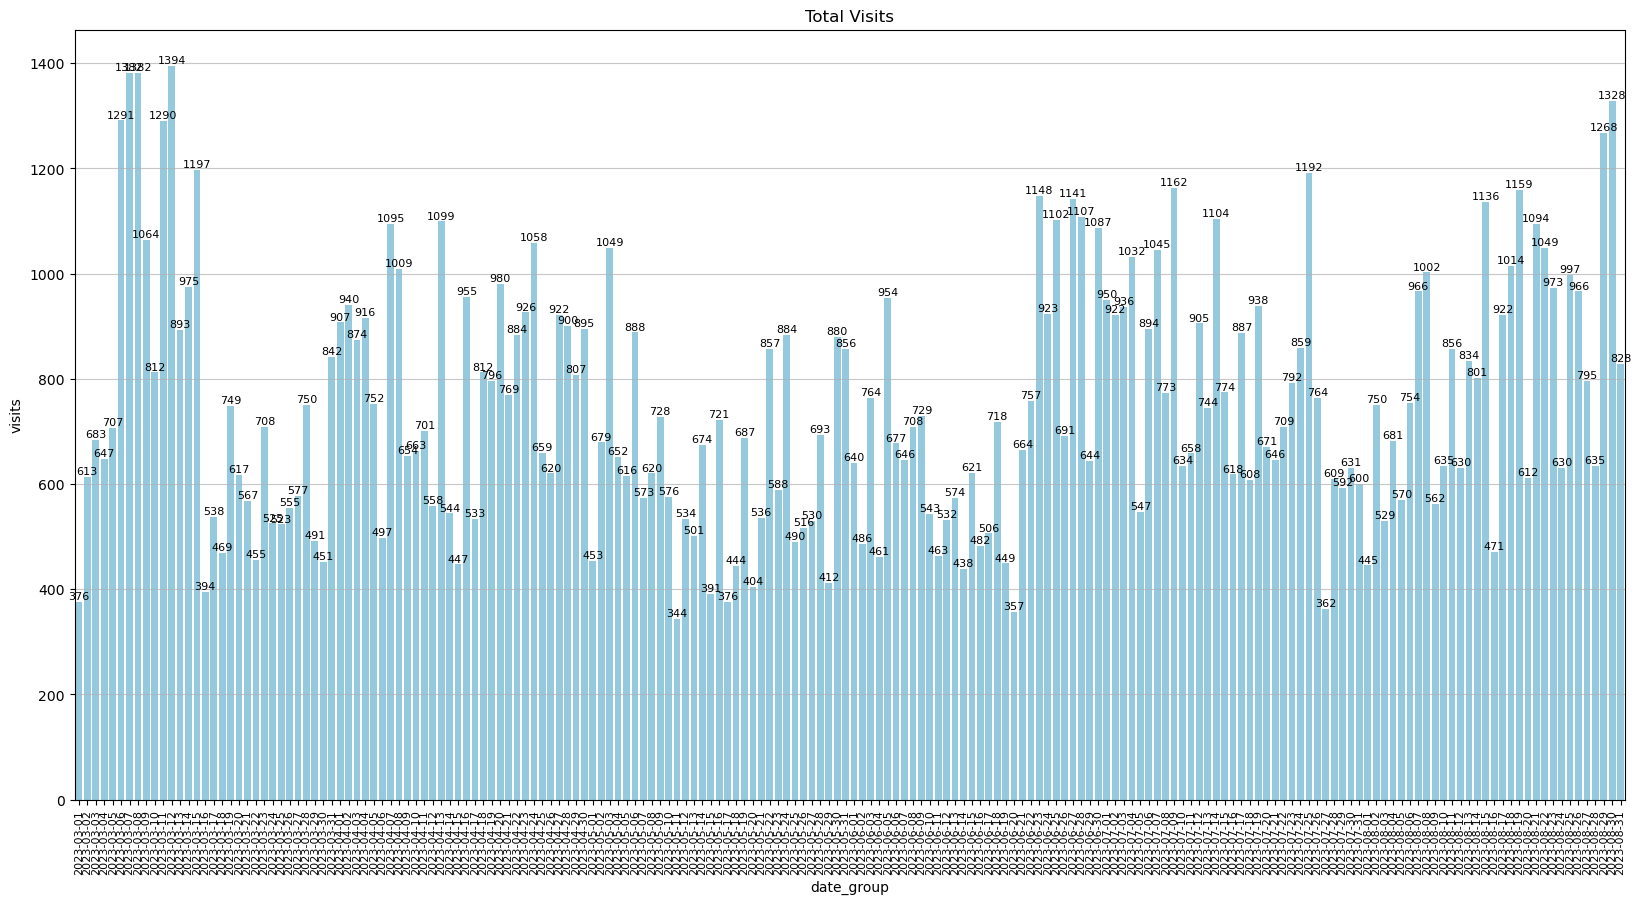

In [57]:
plt.figure(figsize=(20, 10))
gv = sns.barplot(data=visits_for_plot, x='date_group', y='visits', color='skyblue')

for i, v in enumerate(visits_for_plot['visits']):
    plt.text(i, v + 5, str(v), ha='center', fontsize=8)
    
plt.xticks(rotation=90, fontsize=8)
plt.xlabel("date_group")
plt.ylabel("visits")
plt.title("Total Visits")
plt.grid(axis='y', linestyle="-", alpha=0.7)
plt.savefig(f'./charts/chart3.png')
plt.show()

<span style="font-size:23px; color:blue;">ПОСТРОЕНИЕ ГРАФИКА 4</span>

In [59]:
agr_vis_for_plt = visits_itog.reset_index()

In [60]:
agr_vis_for_plt = agr_vis_for_plt.pivot(index='datetime', columns='platform', values='count')#подготавливаем для разбтвки

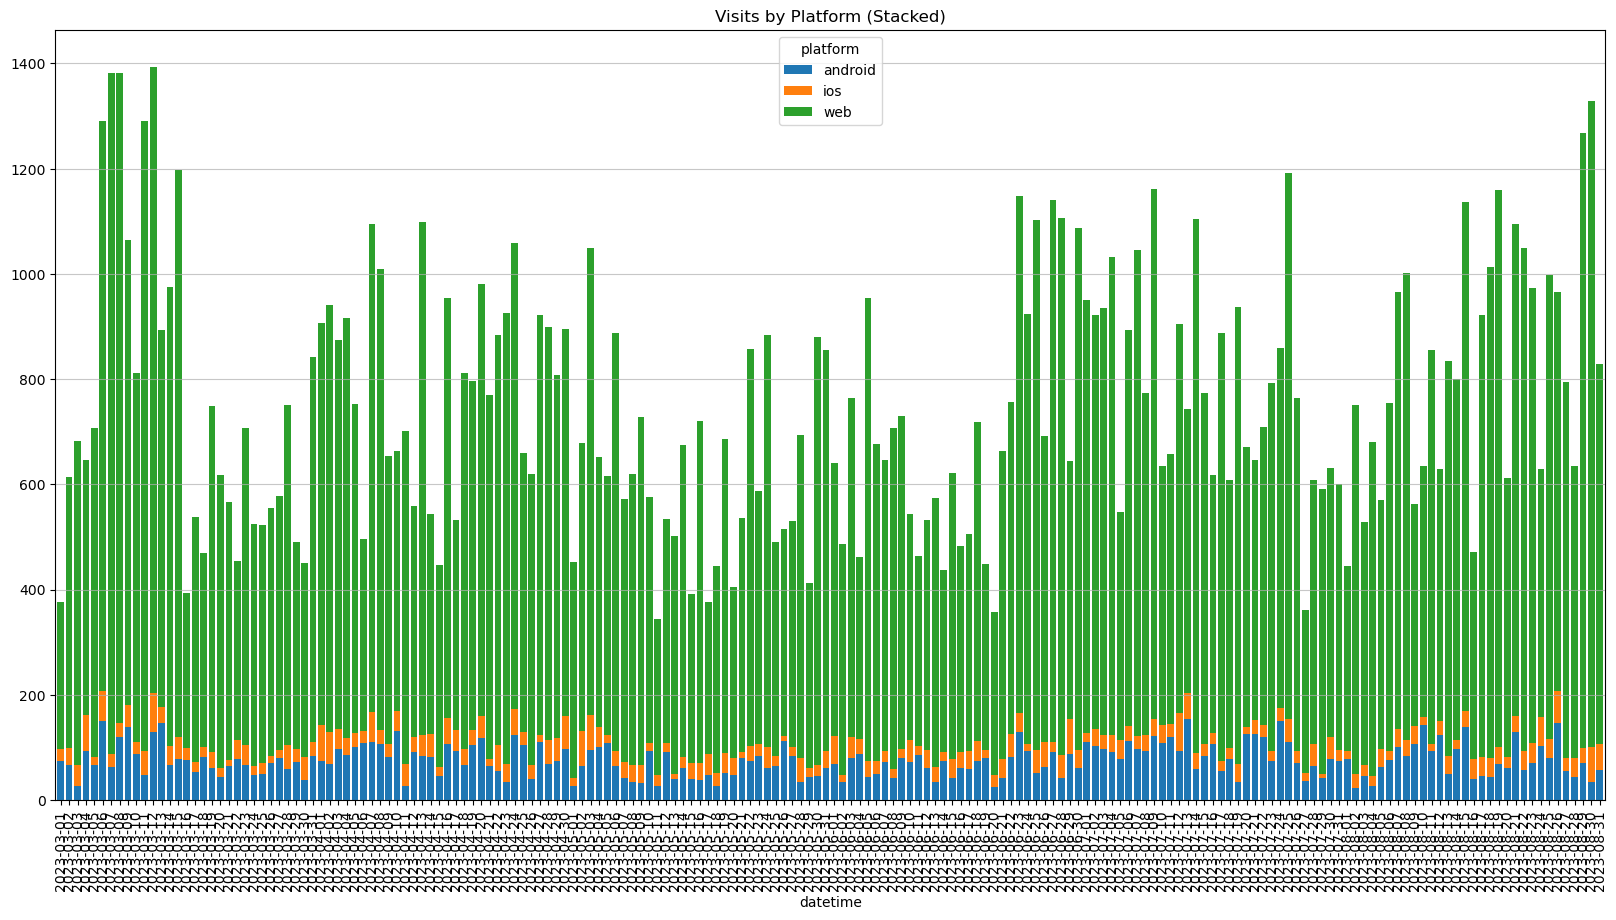

In [61]:
agr_vis_for_plt.plot(kind='bar', stacked=True, figsize=(20, 10), width=0.8)

plt.title("Visits by Platform (Stacked)")
plt.xlabel("datetime")
plt.xticks(rotation=90)#наклон подписей по X
plt.legend(title="platform")
plt.grid(axis='y', linestyle="-", alpha=0.7)
#plt.grid(axis='x', linestyle="-", alpha=0.7)
plt.savefig(f'./charts/chart4.png')
plt.show()

<span style="font-size:23px; color:blue;">ПОСТРОЕНИЕ ГРАФИКА 5</span>

<span style="font-size:18px; color:green;">Агрегируем, чтобы узнать итоговую конверсию</span>

In [64]:
conv_itog = pd.merge(visits_for_plot, regs_for_plot, left_index=True, right_index=True, how='outer')

In [65]:
conv_itog = conv_itog.drop("date_group_y", axis=1)

In [66]:
conv_itog['conversion'] = (100*conv_itog['registrations']/conv_itog['visits']).round().astype(int)

In [67]:
conv_itog = conv_itog.drop(columns=['visits', 'registrations'])

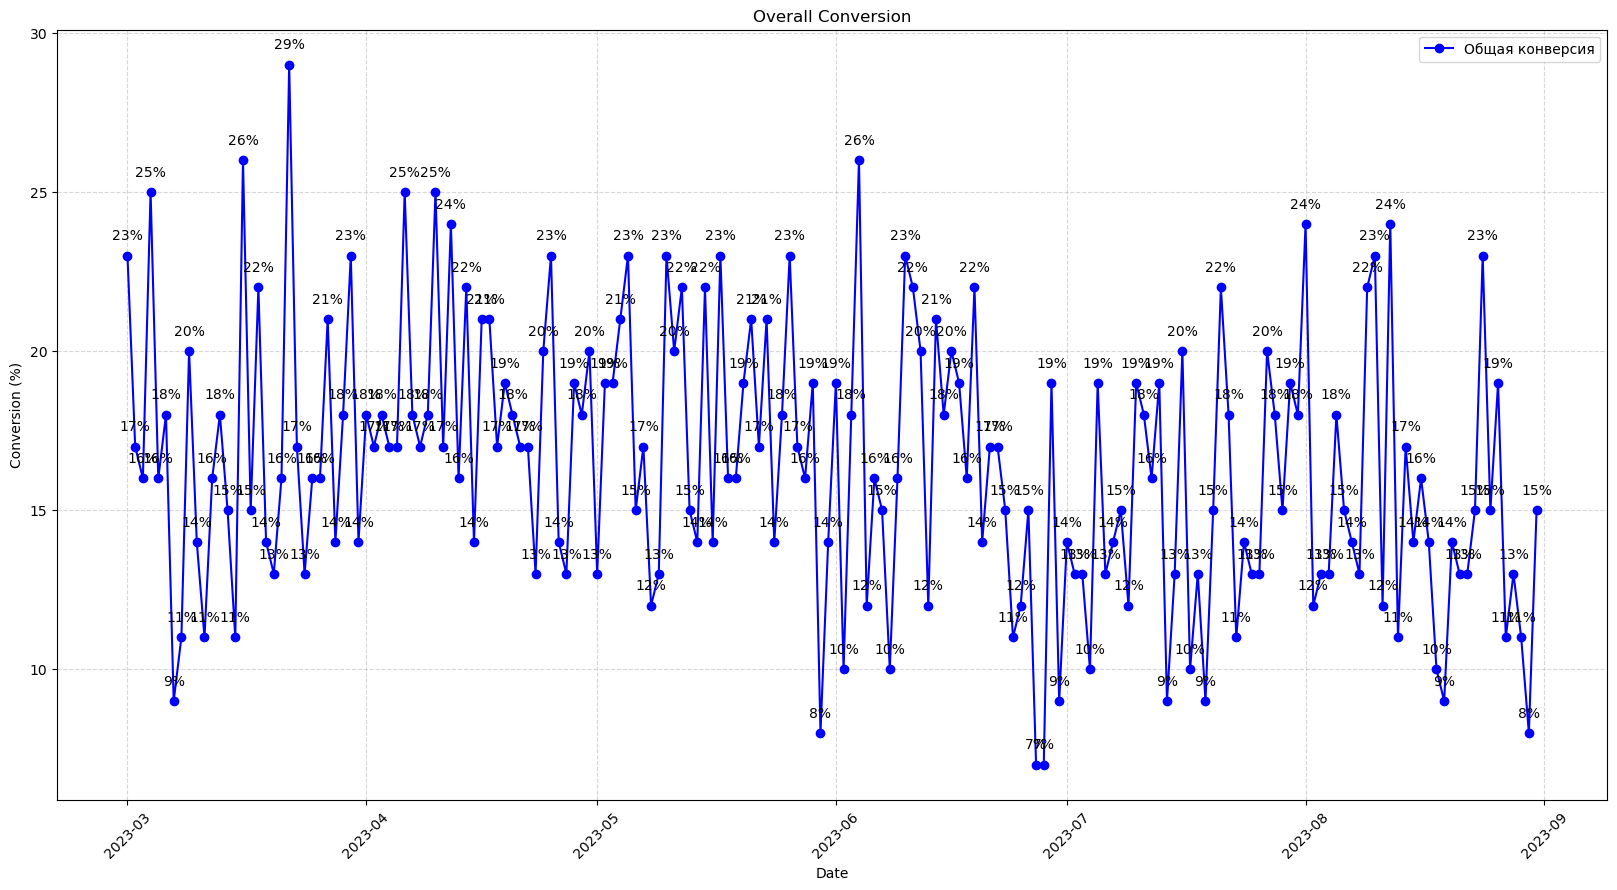

In [68]:
plt.figure(figsize=(20, 10))
plt.plot(conv_itog['date_group_x'], conv_itog['conversion'], marker='o', linestyle='-', color='b', label='Общая конверсия')

for i, v in enumerate(conv_itog['conversion']):
    plt.text(conv_itog['date_group_x'][i], v + 0.5, f"{v}%", ha='center', fontsize=10)

plt.xlabel("Date")
plt.ylabel("Conversion (%)")
plt.xticks(rotation=45)
plt.title("Overall Conversion")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.savefig(f'./charts/chart5.png')
plt.show()

<span style="font-size:23px; color:blue;">ПОСТРОЕНИЕ ГРАФИКА 6</span>

In [70]:
ios_conv = pd.merge(agr_vis_for_plt, agr_reg_for_plt, left_index=True, right_index=True, how='outer')

In [71]:
ios_conv = ios_conv.drop(columns=['android_x', 'web_x','android_y','web_y'])

In [72]:
ios_conv['conversion'] = (100*ios_conv['ios_y']/ios_conv['ios_x']).round().astype(int)

In [73]:
ios_conv = ios_conv.reset_index()

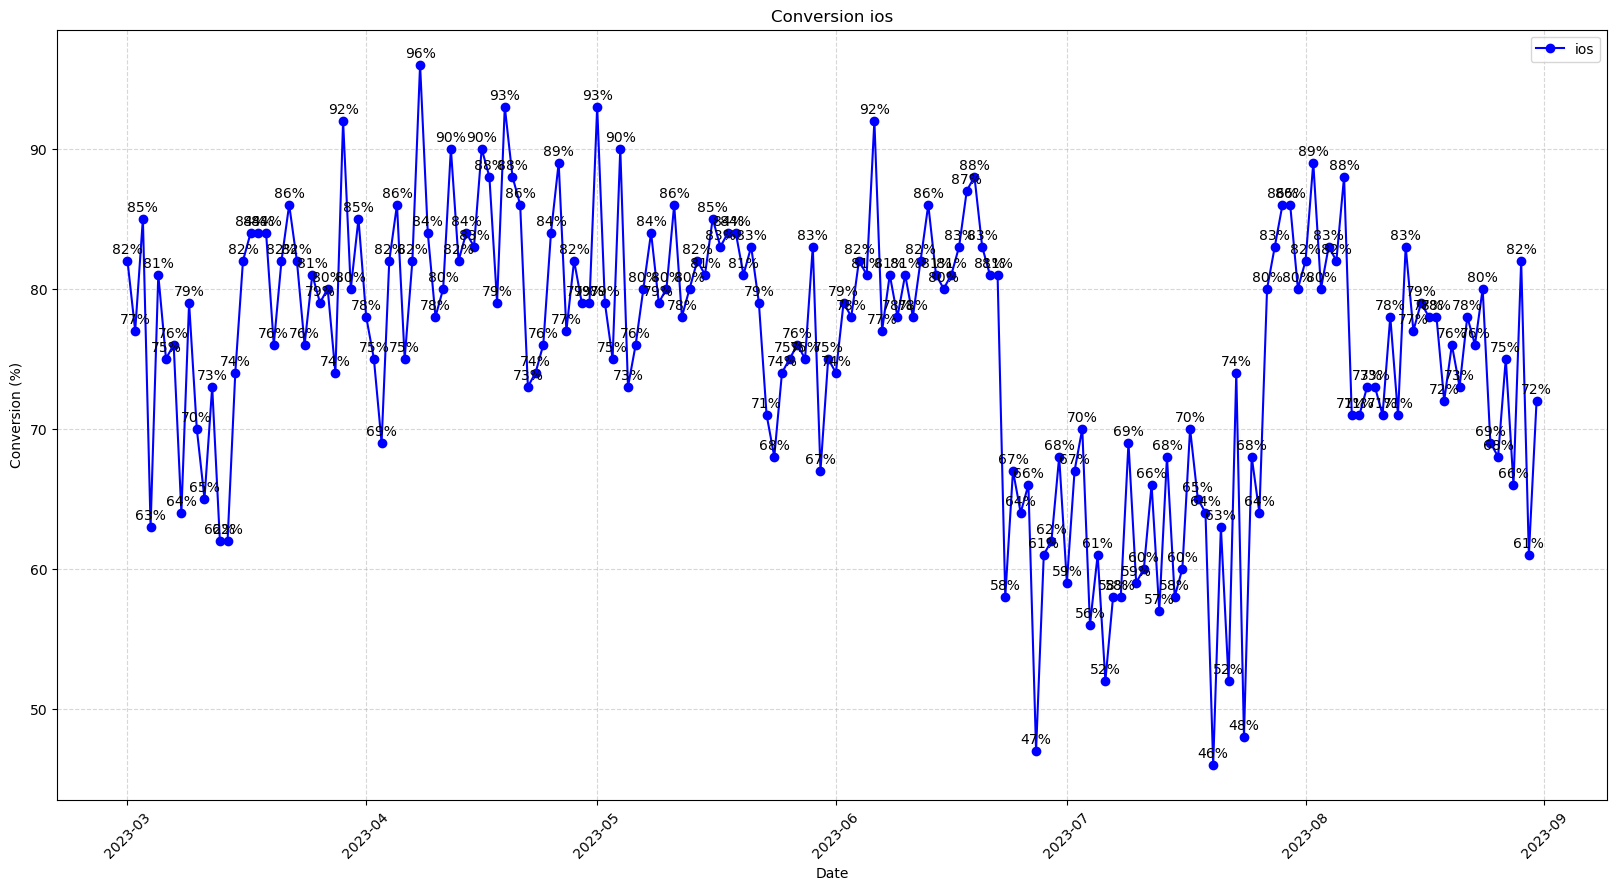

In [74]:
plt.figure(figsize=(20, 10))
plt.plot(ios_conv['datetime'], ios_conv['conversion'], marker='o', linestyle='-', color='b', label='ios')


for i, v in enumerate(ios_conv['conversion']):
    plt.text(ios_conv['datetime'][i], v + 0.5, f"{v}%", ha='center', fontsize=10)


plt.xlabel("Date")
plt.ylabel("Conversion (%)")
plt.xticks(rotation=45)
plt.title("Conversion ios")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.savefig(f'./charts/chart6.png')
plt.show()

<span style="font-size:23px; color:blue;">ПОСТРОЕНИЕ ГРАФИКА 7</span>

In [76]:
web_conv = pd.merge(agr_vis_for_plt, agr_reg_for_plt, left_index=True, right_index=True, how='outer')

In [77]:
web_conv = web_conv.drop(columns=['android_x', 'ios_x','android_y','ios_y'])

In [78]:
web_conv['conversion'] = (100*web_conv['web_y']/web_conv['web_x']).round().astype(int)

In [79]:
web_conv = web_conv.reset_index()

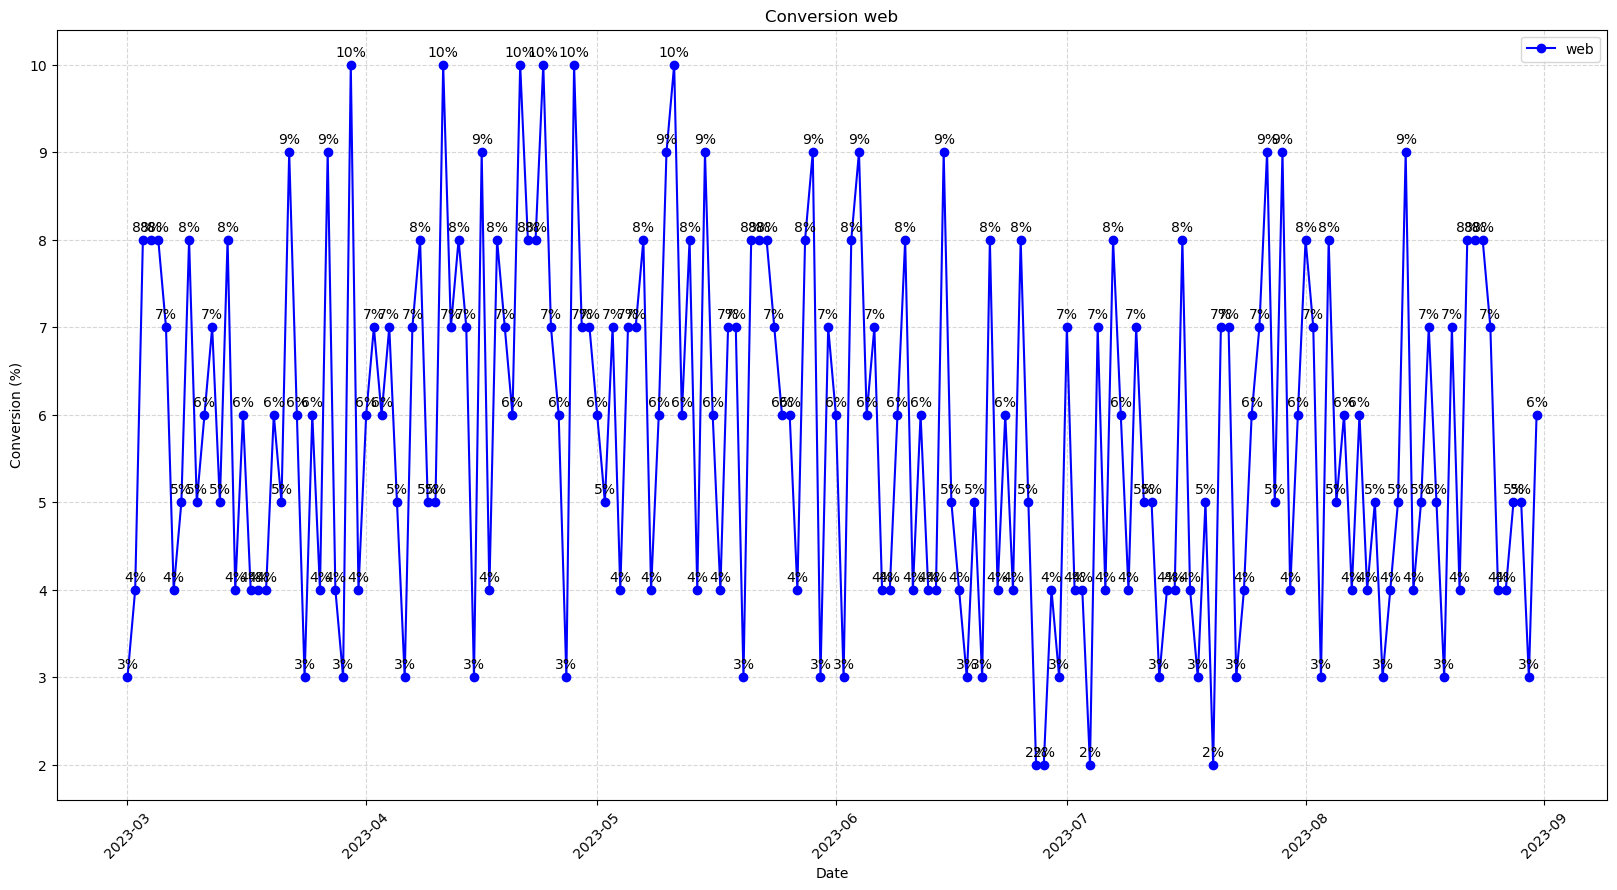

In [80]:
plt.figure(figsize=(20, 10))
plt.plot(web_conv['datetime'], web_conv['conversion'], marker='o', linestyle='-', color='b', label='web')


for i, v in enumerate(web_conv['conversion']):
    plt.text(web_conv['datetime'][i], v + 0.1, f"{v}%", ha='center', fontsize=10)


plt.xlabel("Date")
plt.ylabel("Conversion (%)")
plt.xticks(rotation=45)
plt.title("Conversion web")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.savefig(f'./charts/chart7.png')
plt.show()

<span style="font-size:23px; color:blue;">ПОСТРОЕНИЕ ГРАФИКА 8</span>

In [82]:
android_conv = pd.merge(agr_vis_for_plt, agr_reg_for_plt, left_index=True, right_index=True, how='outer')

In [83]:
android_conv = android_conv.drop(columns=['web_x', 'ios_x','web_y','ios_y'])

In [84]:
android_conv['conversion'] = (100*android_conv['android_y']/android_conv['android_x']).round().astype(int)

In [85]:
android_conv = android_conv.reset_index()

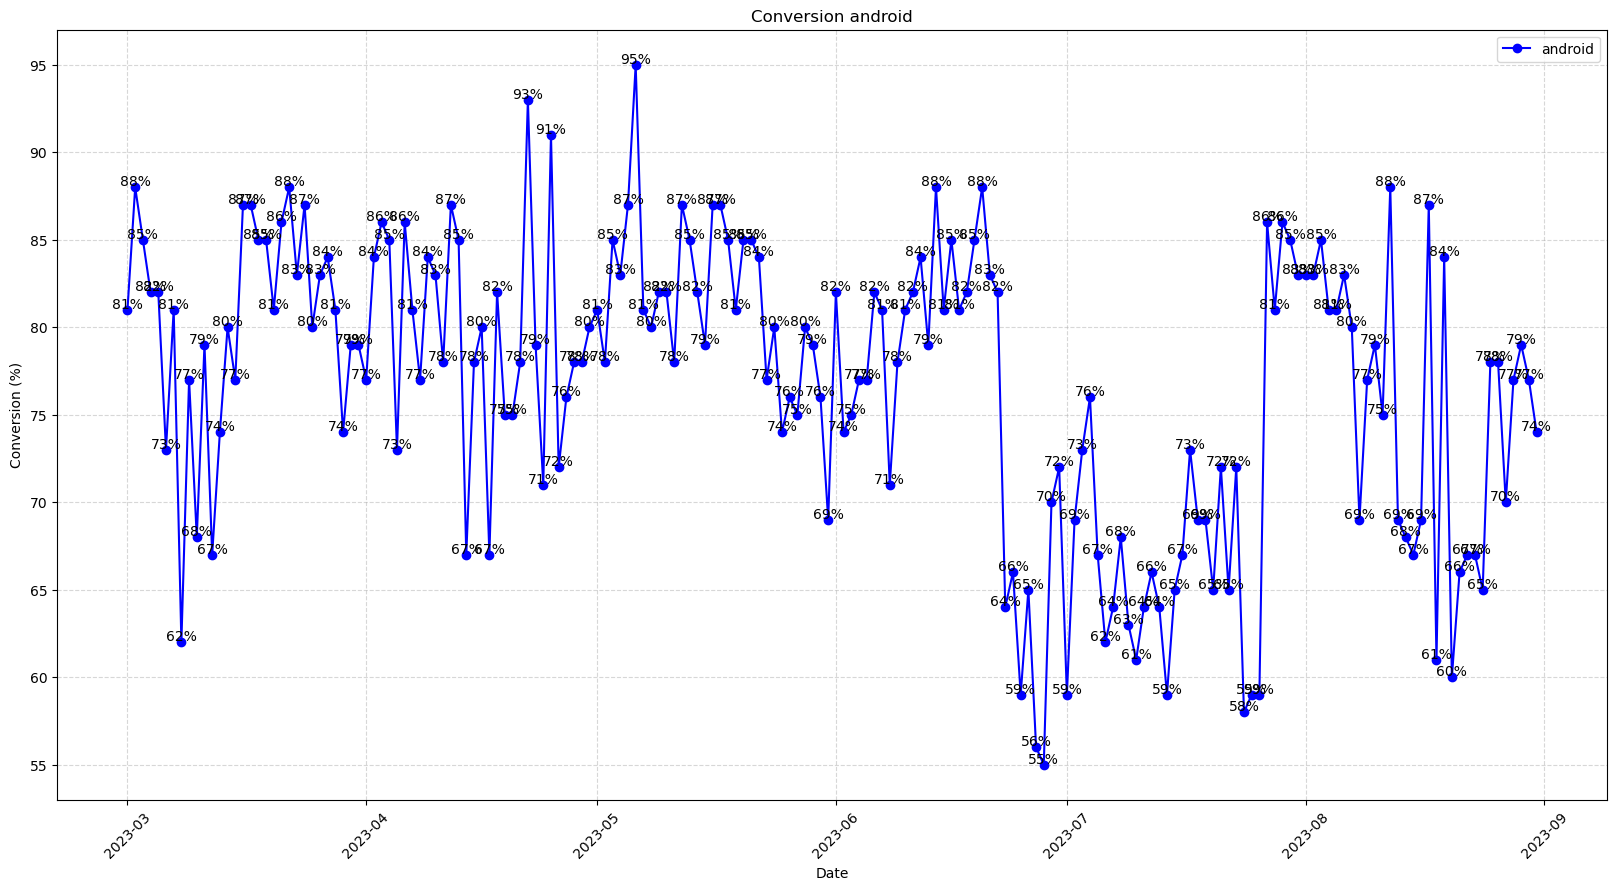

In [86]:
plt.figure(figsize=(20, 10))
plt.plot(android_conv['datetime'], android_conv['conversion'], marker='o', linestyle='-', color='b', label='android')


for i, v in enumerate(android_conv['conversion']):
    plt.text(android_conv['datetime'][i], v + 0.1, f"{v}%", ha='center', fontsize=10)


plt.xlabel("Date")
plt.ylabel("Conversion (%)")
plt.xticks(rotation=45)
plt.title("Conversion android")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.savefig(f'./charts/chart8.png')
plt.show()

<span style="font-size:18px; color:green;">Заканчиваем шаг 3, соединяем 2 итоговые таблицы</span>

In [88]:
merged = pd.merge(visits_itog, regs_itog, left_index=True, right_index=True, how='outer')

In [89]:
merged = merged.reset_index()#мб убрать, но тогда не проходит ренейм по дате

In [90]:
merged = merged.rename(columns={'datetime': 'date_group', 'count_x': 'visits', 'count_y': 'registrations' })

In [91]:
merged['conversion'] = 100*merged['registrations']/merged['visits']

In [92]:
print(merged)

     date_group platform  visits  registrations  conversion
0    2023-03-01  android      75             61   81.333333
1    2023-03-01      ios      22             18   81.818182
2    2023-03-01      web     279              8    2.867384
3    2023-03-02  android      67             59   88.059701
4    2023-03-02      ios      31             24   77.419355
..          ...      ...     ...            ...         ...
547  2023-08-30      ios      66             40   60.606061
548  2023-08-30      web    1227             34    2.770986
549  2023-08-31  android      57             42   73.684211
550  2023-08-31      ios      50             36   72.000000
551  2023-08-31      web     721             46    6.380028

[552 rows x 5 columns]


<span style="font-size:18px; color:green;">Сохраняем результаты шага 3</span>

In [94]:
merged.to_json('./conversion.json')

<span style="font-size:23px; color:blue;">Продолжение шага 4</span>

In [96]:
prev = merged

In [97]:
print(prev)

     date_group platform  visits  registrations  conversion
0    2023-03-01  android      75             61   81.333333
1    2023-03-01      ios      22             18   81.818182
2    2023-03-01      web     279              8    2.867384
3    2023-03-02  android      67             59   88.059701
4    2023-03-02      ios      31             24   77.419355
..          ...      ...     ...            ...         ...
547  2023-08-30      ios      66             40   60.606061
548  2023-08-30      web    1227             34    2.770986
549  2023-08-31  android      57             42   73.684211
550  2023-08-31      ios      50             36   72.000000
551  2023-08-31      web     721             46    6.380028

[552 rows x 5 columns]


<span style="font-size:18px; color:green;">Убираем неиспользуемый столбец</span>

In [99]:
prev = prev.drop("conversion", axis=1)

<span style="font-size:18px; color:green;">Агрегируем, чтобы получить данные визитов и регистраций только по дням</span>

In [101]:
prev_ag = prev.groupby(['date_group'])[['visits','registrations']].agg(['sum'])

<span style="font-size:18px; color:green;">Редактируем названия столбцов</span>

In [103]:
prev_ag = prev_ag.reset_index()

In [104]:
prev_ag = prev_ag.rename(columns={'sum': ''})

In [105]:
prev_ag.columns = prev_ag.columns.droplevel(1)

смотрим, чо вышло

In [107]:
prev_ag['date_group']=pd.to_datetime(prev_ag['date_group'])

In [108]:
print(prev_ag)

    date_group  visits  registrations
0   2023-03-01     376             87
1   2023-03-02     613            106
2   2023-03-03     683            107
3   2023-03-04     647            159
4   2023-03-05     707            115
..         ...     ...            ...
179 2023-08-27     795             88
180 2023-08-28     635             83
181 2023-08-29    1268            143
182 2023-08-30    1328            101
183 2023-08-31     828            124

[184 rows x 3 columns]


<span style="font-size:18px; color:green;">Склеиваем визиты+реги с рекламой</span>

In [110]:
merged = prev_ag.merge(ads_itog, left_on='date_group', right_on='date', how='left')

In [111]:
print(merged)

    date_group  visits  registrations       date                utm_campaign  \
0   2023-03-01     376             87 2023-03-01  advanced_algorithms_series   
1   2023-03-02     613            106 2023-03-02  advanced_algorithms_series   
2   2023-03-03     683            107 2023-03-03  advanced_algorithms_series   
3   2023-03-04     647            159 2023-03-04  advanced_algorithms_series   
4   2023-03-05     707            115 2023-03-05  advanced_algorithms_series   
..         ...     ...            ...        ...                         ...   
179 2023-08-27     795             88 2023-08-27      intro_to_python_course   
180 2023-08-28     635             83 2023-08-28      intro_to_python_course   
181 2023-08-29    1268            143 2023-08-29      intro_to_python_course   
182 2023-08-30    1328            101 2023-08-30      intro_to_python_course   
183 2023-08-31     828            124 2023-08-31      intro_to_python_course   

       sum  
0    212.0  
1    252.0  


<span style="font-size:18px; color:green;">Удаляем date, меняем sum на cost, заполняем 0 и none</span>

In [113]:
merged = merged.drop(columns=['date'])

In [114]:
merged = merged.rename(columns={'sum': 'cost'})

In [115]:
merged['cost'] = merged['cost'].fillna(0)

In [116]:
merged['utm_campaign'] = merged['utm_campaign'].fillna('none')

<span style="font-size:18px; color:green;">Получили итоговую таблицу</span>

In [118]:
print(merged)

    date_group  visits  registrations                utm_campaign   cost
0   2023-03-01     376             87  advanced_algorithms_series  212.0
1   2023-03-02     613            106  advanced_algorithms_series  252.0
2   2023-03-03     683            107  advanced_algorithms_series  202.0
3   2023-03-04     647            159  advanced_algorithms_series  223.0
4   2023-03-05     707            115  advanced_algorithms_series  265.0
..         ...     ...            ...                         ...    ...
179 2023-08-27     795             88      intro_to_python_course  222.0
180 2023-08-28     635             83      intro_to_python_course  223.0
181 2023-08-29    1268            143      intro_to_python_course  190.0
182 2023-08-30    1328            101      intro_to_python_course  109.0
183 2023-08-31     828            124      intro_to_python_course  215.0

[184 rows x 5 columns]


<span style="font-size:23px; color:blue;">ПОСТРОЕНИЕ ГРАФИКА 9</span>

In [120]:
ads_ov = merged

In [121]:
print(ads_ov)

    date_group  visits  registrations                utm_campaign   cost
0   2023-03-01     376             87  advanced_algorithms_series  212.0
1   2023-03-02     613            106  advanced_algorithms_series  252.0
2   2023-03-03     683            107  advanced_algorithms_series  202.0
3   2023-03-04     647            159  advanced_algorithms_series  223.0
4   2023-03-05     707            115  advanced_algorithms_series  265.0
..         ...     ...            ...                         ...    ...
179 2023-08-27     795             88      intro_to_python_course  222.0
180 2023-08-28     635             83      intro_to_python_course  223.0
181 2023-08-29    1268            143      intro_to_python_course  190.0
182 2023-08-30    1328            101      intro_to_python_course  109.0
183 2023-08-31     828            124      intro_to_python_course  215.0

[184 rows x 5 columns]


In [122]:
print(ads_ov.groupby("utm_campaign")["cost"].agg(["sum"]).reset_index())

                 utm_campaign     sum
0  advanced_algorithms_series  2824.0
1      intro_to_python_course  4690.0
2                        none     0.0
3          ui_ux_design_drive  4209.0
4    virtual_reality_workshop  9031.0
5     women_in_tech_symposium  6780.0


<span style="font-size:18px; color:green;">Смотрим, какие рекламные кампании проводились и когда</span>

In [124]:
print(ads_ov.groupby("utm_campaign")["date_group"].agg(["min", "max"]).reset_index().sort_values(by="min"))

                 utm_campaign        min        max
0  advanced_algorithms_series 2023-03-01 2023-03-15
2                        none 2023-03-16 2023-08-05
4    virtual_reality_workshop 2023-03-25 2023-05-06
3          ui_ux_design_drive 2023-05-19 2023-06-09
5     women_in_tech_symposium 2023-06-21 2023-07-26
1      intro_to_python_course 2023-08-06 2023-08-31


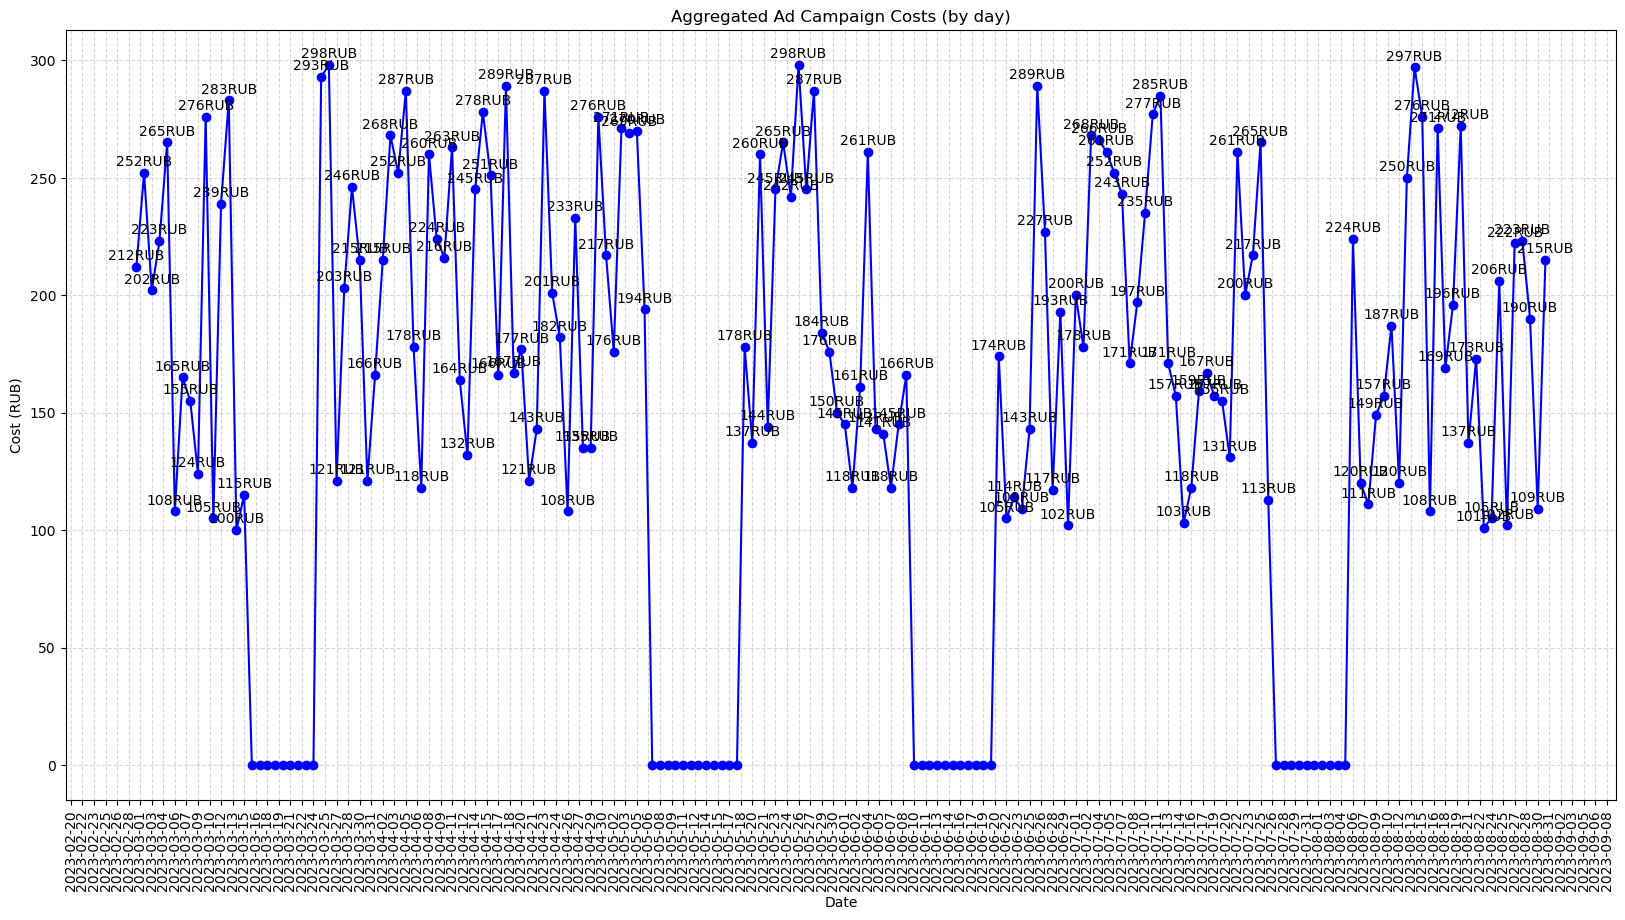

In [125]:
plt.figure(figsize=(20, 10))
plt.plot(ads_ov['date_group'], ads_ov['cost'], marker='o', linestyle='-', color='b')


for i, v in enumerate(ads_ov['cost'].round().astype(int)):
    if v>0:#мб не надо
        plt.text(ads_ov['date_group'][i], v + 3, f"{v}RUB", ha='center', fontsize=10)

plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=200))
plt.xlabel("Date")
plt.ylabel("Cost (RUB)")
plt.xticks(rotation=90)
plt.title("Aggregated Ad Campaign Costs (by day)")

plt.grid(True, linestyle="--", alpha=0.5)
plt.savefig(f'./charts/chart9.png')
plt.show()

<span style="font-size:23px; color:blue;">ПОСТРОЕНИЕ ГРАФИКА 10</span>

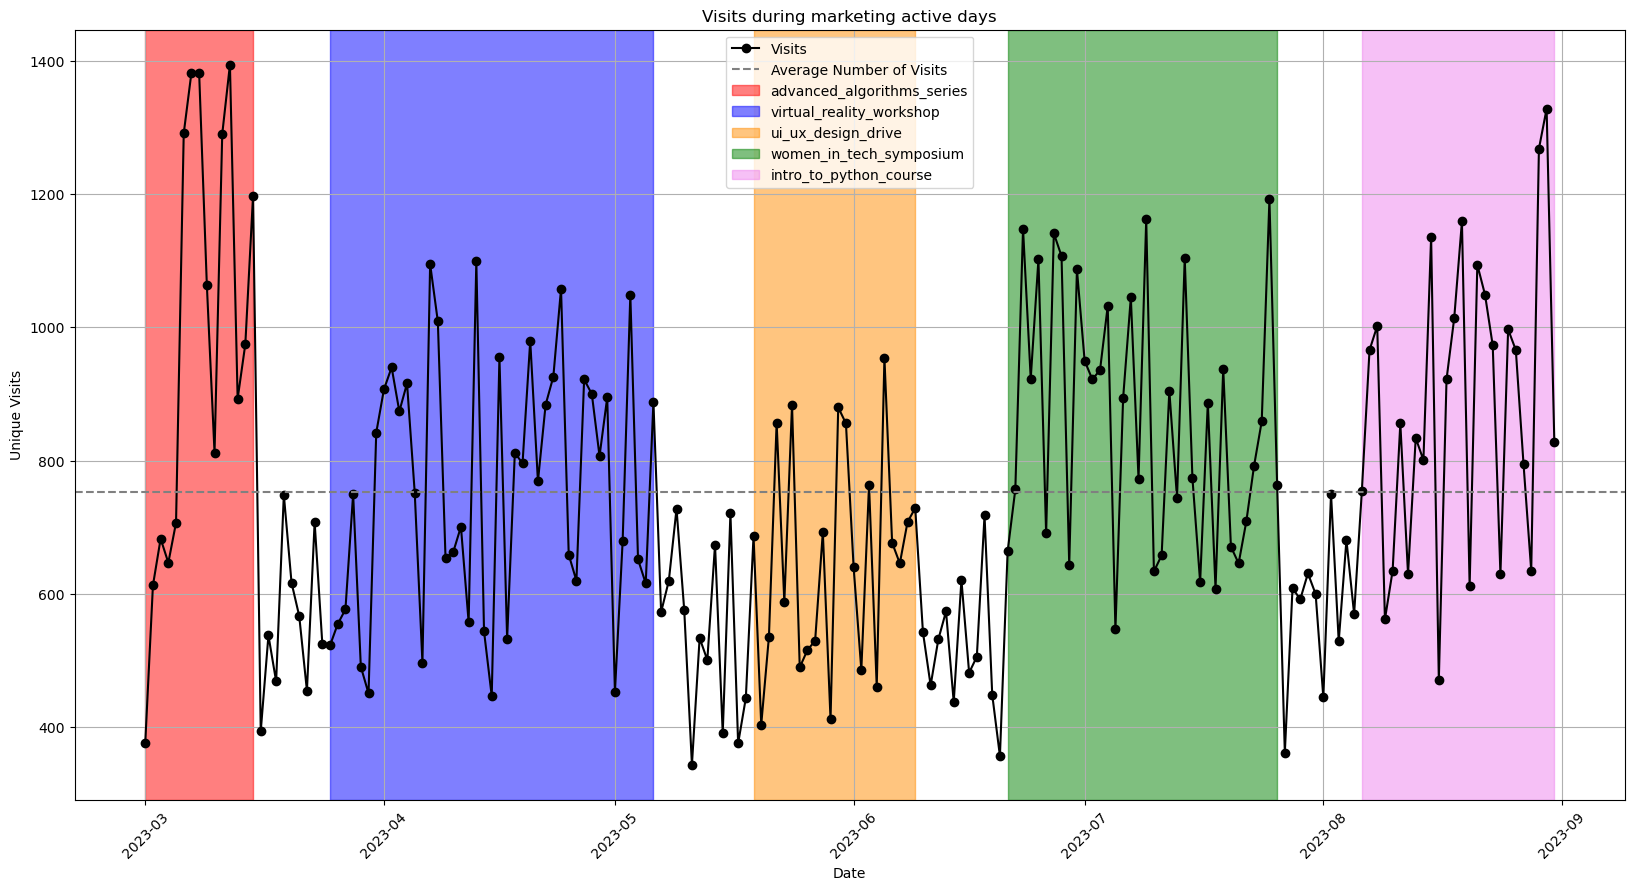

In [127]:
fig,ax = plt.subplots(figsize=(20, 10))
ax.plot(ads_ov["date_group"], ads_ov["visits"], marker="o", linestyle="-", color="black", label="Visits")#сам график

avg_visits = ads_ov["visits"].mean()#среднее
ax.axhline(avg_visits, color="gray", linestyle="--", label="Average Number of Visits")

ax.axvspan(pd.to_datetime('2023-03-01'), pd.to_datetime('2023-03-15'), color='red', alpha=0.5, label='advanced_algorithms_series')#кампании
ax.axvspan(pd.to_datetime('2023-03-25'), pd.to_datetime('2023-05-06'), color='blue', alpha=0.5, label='virtual_reality_workshop')
ax.axvspan(pd.to_datetime('2023-05-19'), pd.to_datetime('2023-06-09'), color='darkorange', alpha=0.5, label='ui_ux_design_drive')
ax.axvspan(pd.to_datetime('2023-06-21'), pd.to_datetime('2023-07-26'), color='green', alpha=0.5, label='women_in_tech_symposium')
ax.axvspan(pd.to_datetime('2023-08-06'), pd.to_datetime('2023-08-31'), color='violet', alpha=0.5, label='intro_to_python_course')

ax.set_xlabel("Date")
ax.set_ylabel("Unique Visits")
ax.set_title("Visits during marketing active days")
ax.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.savefig(f'./charts/chart10.png')
plt.show()

<span style="font-size:23px; color:blue;">ПОСТРОЕНИЕ ГРАФИКА 11</span>

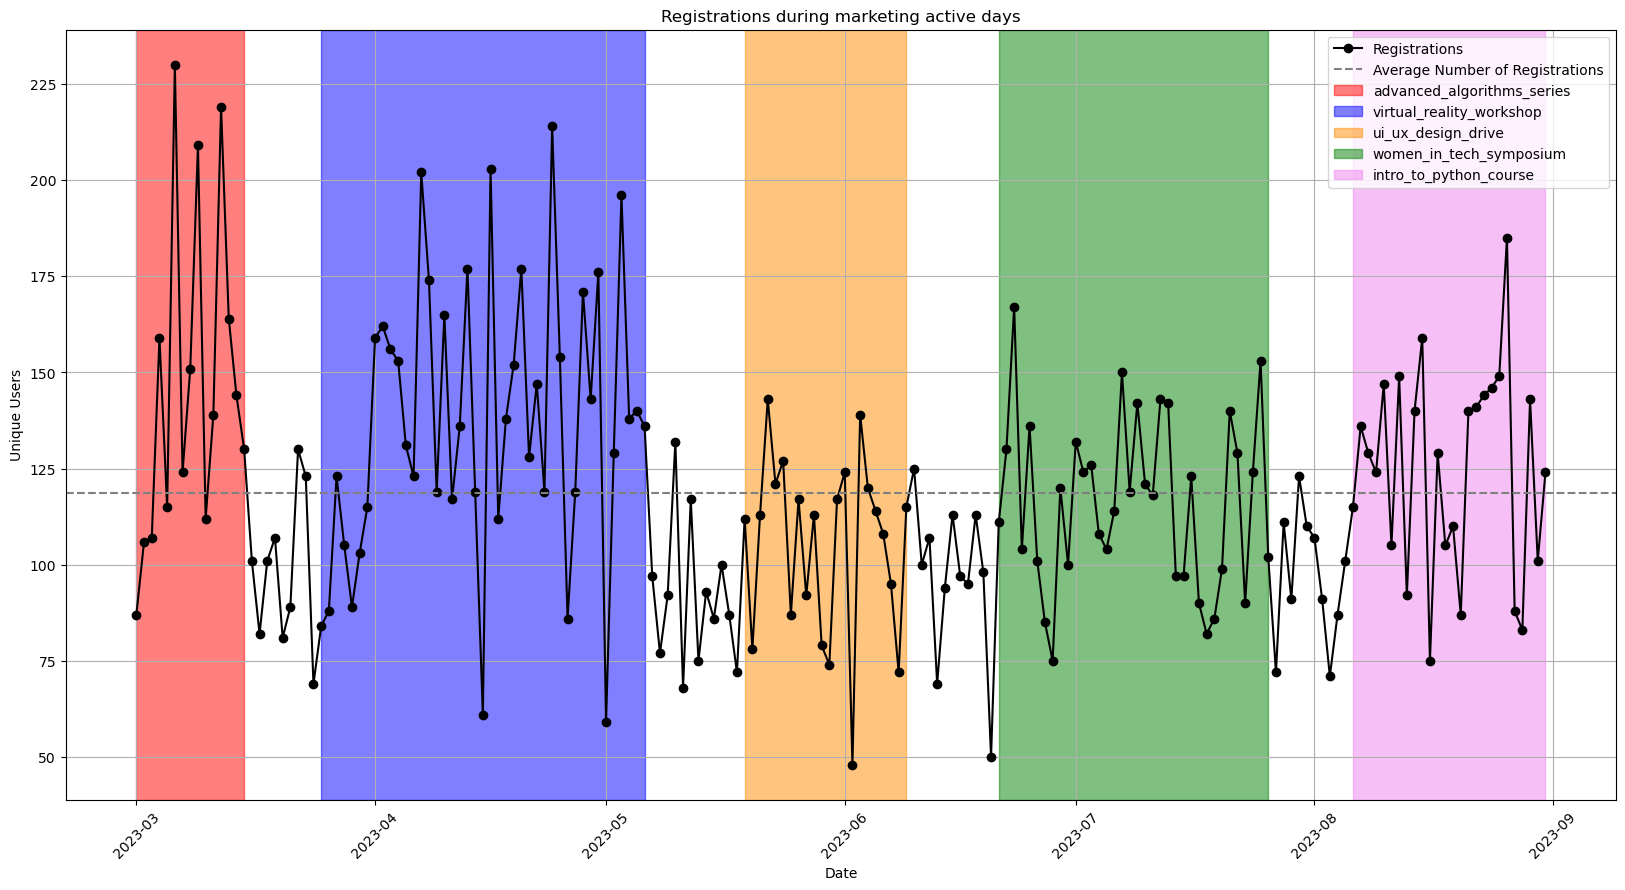

In [129]:
fig,ax = plt.subplots(figsize=(20, 10))
ax.plot(ads_ov["date_group"], ads_ov["registrations"], marker="o", linestyle="-", color="black", label="Registrations")#сам график

avg_visits = ads_ov["registrations"].mean()#среднее
ax.axhline(avg_visits, color="gray", linestyle="--", label="Average Number of Registrations")

ax.axvspan(pd.to_datetime('2023-03-01'), pd.to_datetime('2023-03-15'), color='red', alpha=0.5, label='advanced_algorithms_series')#кампании
ax.axvspan(pd.to_datetime('2023-03-25'), pd.to_datetime('2023-05-06'), color='blue', alpha=0.5, label='virtual_reality_workshop')
ax.axvspan(pd.to_datetime('2023-05-19'), pd.to_datetime('2023-06-09'), color='darkorange', alpha=0.5, label='ui_ux_design_drive')
ax.axvspan(pd.to_datetime('2023-06-21'), pd.to_datetime('2023-07-26'), color='green', alpha=0.5, label='women_in_tech_symposium')
ax.axvspan(pd.to_datetime('2023-08-06'), pd.to_datetime('2023-08-31'), color='violet', alpha=0.5, label='intro_to_python_course')

ax.set_xlabel("Date")
ax.set_ylabel("Unique Users")
ax.set_title("Registrations during marketing active days")
ax.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.savefig(f'./charts/chart11.png')
plt.show()

<span style="font-size:18px; color:green;">Сброс лимита вывода, чтобы посмотреть merged</span>

In [131]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

<span style="font-size:18px; color:green;">Функция, возвращающая дефолтный лимит</span>

In [133]:
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

<span style="font-size:18px; color:green;">Расставляем стобцы, как в задании</span>

In [135]:
merged = merged[["date_group", "visits", "registrations", "cost", "utm_campaign"]]

<span style="font-size:18px; color:green;">Готово! Сохраняем в json</span>

In [137]:
merged.to_json('./ads.json')